## WP2.2 
### normalisation and standardisation of water quality measures. 

#### Part 1: Instrument  to Intrument harmonisation:
1. generate **daily** results for some sites, for the year 2020 (all instruments available)
2. compare results for the same algorithm, between sensors: ETM-OLI, OLI-MSI
(Choose sites to ***be re-used for calibration against in-situ data*** (i.e. lake victoria)
3. Move on to harmonisation between measurements!
 
#### Part 2: Measurement to Measurement harmonisation:
1. generate results for all sites
   - results include the observed distribution of each WQ variable - this is in quantiles
3. compile results to a singlle dataset
4. choose a reference measrement
5. determine the adjustment parameters to adjust other measures to the statistical space of the reference measure
   - this includes the **time intervals** to use 
   - Simplest case: match the medians and the 1% quantile **for all times and places**
   - More sophisticated : match probability distributions. 
6. 
   - 

In [ ]:
# ---  dependencies --- 

import datacube
import numpy as np
import xarray as xr
import scipy as sp
import gc
import json
from scipy import stats
import pandas as pd     #for dates
from odc.ui import image_aspect
from deafrica_tools.plotting import rgb # used in some visualisation for debugging
dc = datacube.Datacube(app='DoinWhatImdoin') #testing what difference the 'app' value makes...

In [2]:
# --- pathnames 
# results files are stored in my space for now
results_directory = '/home/jovyan/deafrica_water_quality/wq_results/'
WP12              = '/home/jovyan/dev/deafrica_water_quality/WP1.2'


In [17]:
# --- run code for functions that are called
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_WQ_functions.py
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_Build_annual_dataset-1.0.ipynb   #for now I have kept these functions in a notebook for the markdown

# Part 1, Instrument to Instrument Harmonisation
- 

# Part 2, Measurement to Measurement Harmonisation
- Cells here demonstrate the basic concepts, demonstrated in  WP1.2.

## 2.1 Run the geomedian analysis for all target sites

## 2.2 Read in results from an annual geomedian analysis

In [19]:
path = results_directory
filename = 'wq_raw_Lake_vic_algae.nc'
placename  = 'Lake_vic_algae'
def read_dataset(filename):
    ds   = xr.open_dataset(filename).load(); ds.close()
    return(ds)

In [12]:
wq_results = read_dataset(path+filename)

#### Demonstrates plotting of the results, 
#### AND, calculation of scale and offset parameters for each instument

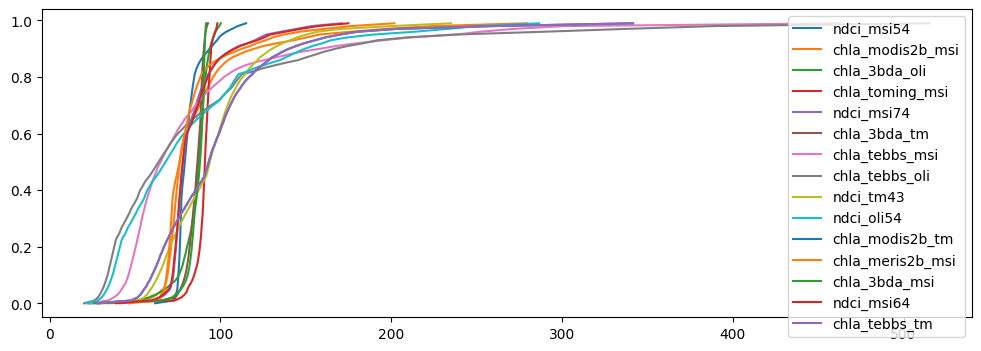

In [20]:
# --- check some of the results ---
#     a little bit of analysis and normalisation to be able to view the results comparatively
#    
wq_results['chla_offset'] = ('chla_measure'), np.zeros((wq_results.sizes['chla_measure']))
wq_results['chla_scale' ] = ('chla_measure'), np.zeros((wq_results.sizes['chla_measure']))

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

exclude = []
exclude = ['chla_tebbs_oli','chla_tebbs_msi','chla_tebbs_tm']
exclude = []

reftime    =  wq_results.time[0:24]   
targettime =  wq_results.time[0:24]  
displaytime = wq_results.time[0:24]
chla_refalg = 'chla_modis2b_msi'
chla_refmed = wq_results.loc[dict(time = (reftime), chla_measure = chla_refalg, quantile=(wq_results['quantile'][50]))].chla.mean().values
chla_ref01  = wq_results.loc[dict(time = (reftime), chla_measure = chla_refalg, quantile=(wq_results['quantile'][ 0]))].chla.mean().values


for name in (set(wq_results.chla_measure.values) - set(exclude)):
    chla_med  = wq_results.loc[dict(time = (targettime), chla_measure = name, quantile=(wq_results['quantile'][50]))].chla.mean().values
    chla_01   = wq_results.loc[dict(time = (targettime), chla_measure = name, quantile=(wq_results['quantile'][ 0]))].chla.mean().values
    scale  =  (chla_refmed - chla_ref01) / (chla_med - chla_01)
    offset =  chla_refmed - chla_med*scale        
    wq_results['chla_offset'].loc[dict(chla_measure=name)] = offset
    wq_results['chla_scale' ].loc[dict(chla_measure=name)] = scale
    plt.plot((wq_results.loc[dict(time = (displaytime),chla_measure=name , place=placename , quantile=(wq_results['quantile'] <1))].median(dim=('time'))['chla'] * scale) + offset\
#          / results.loc[dict(chla_measure=name  ,place=placename,quantile=results['quantile'][99])]['chla'].median(dim=('time'))
         ,wq_results['quantile'][wq_results['quantile']<1],
            label=name)
plt.legend(loc='best')
plt.show()


#### Demonstrates the *dynamic application* of the scale and offset parameters:

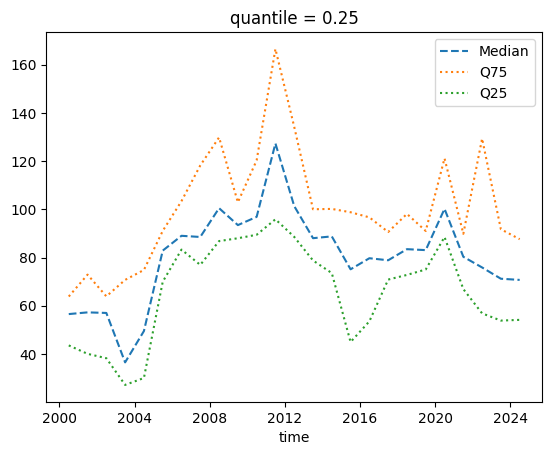

In [541]:
(ds.chla * wq_results.chla_scale + wq_results.chla_offset).median(dim=('chla_measure','x','y')).plot(linestyle = '--',label='Median')
(ds.chla * wq_results.chla_scale + wq_results.chla_offset).quantile(0.75,dim=('chla_measure','x','y')).plot(linestyle=':',label='Q75')
(ds.chla * wq_results.chla_scale + wq_results.chla_offset).quantile(0.25,dim=('chla_measure','x','y')).plot(linestyle=':',label='Q25')
plt.legend(loc='best')

In [455]:
# this mais may be junk , not sure...
# move this code out.
tss_refalg = 'tsm_lym_oli'
for year in wq_results.time[0:24]:
    
    tss_refmed   = wq_results.loc[dict(time = (year), tss_measure = tss_refalg, quantile=(wq_results['quantile'][50]))].tss.mean().values
    tss_ref01    = wq_results.loc[dict(time = (year), tss_measure = tss_refalg, quantile=(wq_results['quantile'][ 0]))].tss.mean().values    
    for alg in wq_results.tss_measure:
        tss_med  = wq_results.loc[dict(time = (year), tss_measure = alg, quantile=(wq_results['quantile'][50]))].tss.mean().values
        tss_01   = wq_results.loc[dict(time = (year), tss_measure = alg, quantile=(wq_results['quantile'][ 0]))].tss.mean().values
        scale  =  (tss_refmed - tss_ref01) / (tss_med - tss_01)
        offset =  tss_refmed - tss_med*scale        
        wq_results['tss_scale'].loc[dict(time = (year), tss_measure = alg  , place=placename)]  = scale
        wq_results['tss_offset'].loc[dict(time = (year), tss_measure = alg , place=placename)] = offset
        

